# Holmes using USCRN insitu data
We will try to recreate the results from Holmes et. al. by studying the linear relationship between LST and Ka(H) brightness temperature.

We have all stations from the USCRN network LST(lat,lon,time)

* Test Holmes' hypothesis using each station individually.  

* Test it using data from all stations in a given moment in time.  

* Test it using all data from all stations.

$$ HolmesLST(Ka_H) = a * Ka_H + b $$
$$ a = 1.11 $$
$$ b = -15.2 $$


In [1]:
# Libraries
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr
# Custom functions

import sys
sys.path.append("../src")
from processing import load_zip, apply_scaling

# Global
%matplotlib inline

data_path = "../data/raw/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.zip"
selected_network = "USCRN"

ka_path = '../data/raw/ka.zip'

lst = "surface_temperature"

In [2]:
ismn_data = ISMN_Interface(data_path, parallel=True)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


In [3]:
# Get the ids for the USCRN network and subset from the whole dataset
ids = ismn_data.get_dataset_ids(
    variable="surface_temperature", filter_meta_dict={"network": selected_network}
)
uscrn_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ..\data\raw\python_metadata\Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


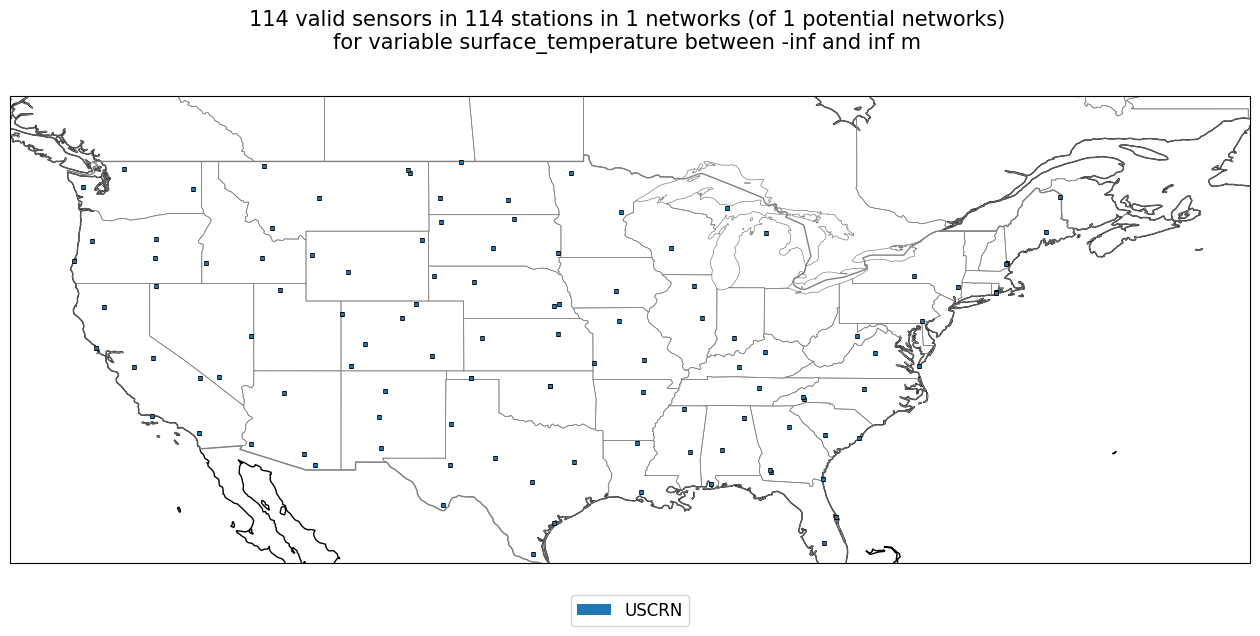

In [4]:
# We can even plot station locations
import cartopy.crs as ccrs

# plot available station on a map
fig, ax = plt.subplots(
    1, 1, figsize=(16, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)
uscrn_data.plot_station_locations(
    "surface_temperature", ax=ax, markersize=5, text_scalefactor=3
)
ax.set_extent([-128, -57, 26, 47])  # US aproximate coordinate range
plt.show()

In [5]:
# Recover the data only from the sensors that have good timeseries.
ids = uscrn_data.get_dataset_ids("surface_temperature")
valid_sensors = []
for network, station, sensor in uscrn_data.collection.iter_sensors(
    variable="surface_temperature", depth=[0, 0]
):
    if np.min(sensor.data["surface_temperature"]) > -100:
        valid_sensors.append((network, station, sensor))

len(valid_sensors)

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(
c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecate

37

In [6]:
# For each sensor, save ascending and descendig passes (6pm and 6am), also lattitude and longitude. save it into a xarray dataset

network, station, sensor = valid_sensors[0]

timeseries = uscrn_data[network.name][station.name][sensor.name].data

ascending_ts = timeseries[timeseries.index.hour == 18]
descending_ts = timeseries[timeseries.index.hour == 6]

lon = uscrn_data[network.name][station.name][sensor.name].metadata["longitude"][1]
lat = uscrn_data[network.name][station.name][sensor.name].metadata["latitude"][1]

c:\Users\andre\Desktop\VS_Code\PMW_LST\.venv\lib\site-packages\ismn\filehandlers.py:659: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  return pd.read_csv(


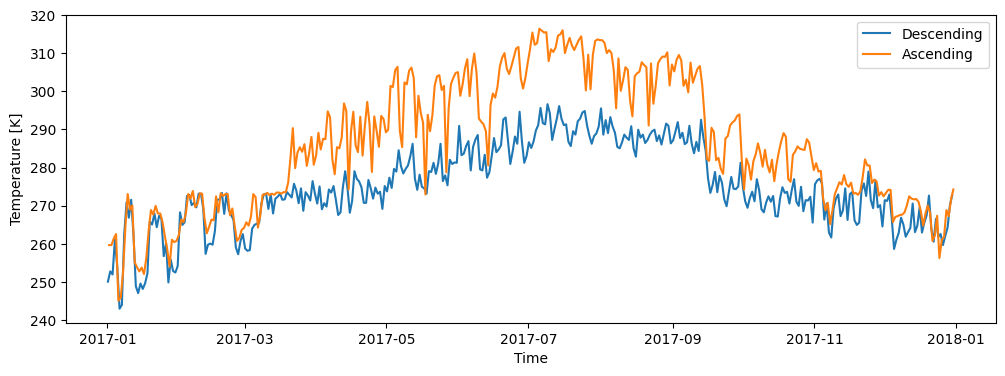

In [7]:
# Visualise 6pm-6am data from a station
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(descending_ts["surface_temperature"] + 273.15, label="Descending")
ax.plot(ascending_ts["surface_temperature"] + 273.15, label="Ascending")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Time")
ax.legend()

plt.show()

In [8]:
# Retrieve Ka band data:
ka_dataset = load_zip(ka_path)
ka_dataset = apply_scaling(ka_dataset)

Loading zipfile from ../data/raw/ka.zip


100%|██████████| 754/754 [00:28<00:00, 26.73it/s]


Applying scaling


100%|██████████| 3/3 [00:12<00:00,  4.23s/it]


In [9]:
# Select closest pixel to sensor
node_data = ka_dataset.sel({"lat": lat, "lon": lon}, method="nearest")

# Separate Ascending and descending passes
ka_ascending = node_data.where(node_data.Pass == "Ascending", drop=True)
ka_descending = node_data.where(node_data.Pass == "Descending", drop=True)

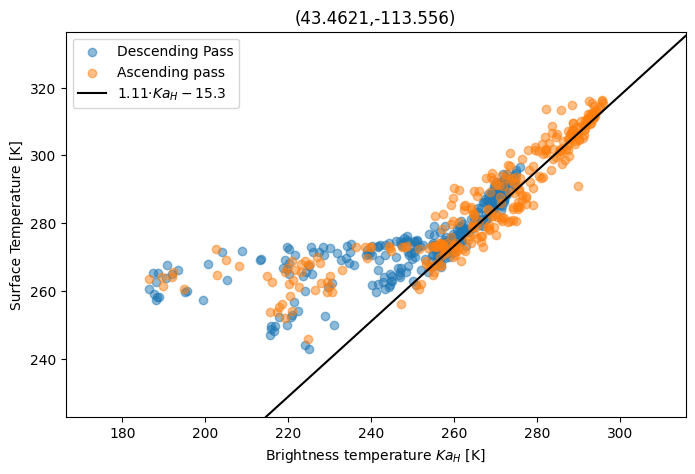

In [10]:
# Quick plot to show Holme's law and data
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Descending pass
ax.scatter(
    x=ka_descending["Brightness Temperature (H)"][
        :-1
    ],  # We dont have measurements for the last passing for some reason
    y=descending_ts["surface_temperature"].values + 273.15,
    label="Descending Pass",
    alpha=0.5,
)

# Ascending Pass
ax.scatter(
    x=ka_ascending["Brightness Temperature (H)"][
        :-1
    ],  # We dont have measurements for the last passing for some reason (last measure is 30-Dec-2017 instead of 31-Dec-2017)
    y=ascending_ts["surface_temperature"].values + 273.15,
    label="Ascending pass",
    alpha=0.5,
)

# Holmes regression formula LST = a · Ka + b
ax.axline(slope=1.11, xy1=(0, -15.3), label="$1.11·Ka_H -15.3$", color="black")

# Plot config
ax.set_xlabel("Brightness temperature $Ka_H$ [K]")
ax.set_ylabel("Surface Temperature [K]")
ax.set_title(f"({lat},{lon})")

# Spans using min-max values from all 4 timeseries plus a margin of 20 Kelvin
ax.set_xlim(
    (
        min(ka_descending["Brightness Temperature (H)"][:-1]) - 20,
        max(ka_ascending["Brightness Temperature (H)"][:-1]) + 20,
    )
)
ax.set_ylim(
    (
        min(descending_ts["surface_temperature"].values + 273.15) - 20,
        max(ascending_ts["surface_temperature"].values + 273.15) + 20,
    )
)


ax.legend()
fig.show()

# Insights

While validating some of the sensors I found out that the linear relationship breaks when the temperature is below 273 K (0°C) but not allways. This is likelly due to **the surface being covered in snow.**.  


In [24]:
# TODO: Represent all data from all stations separatelly and see if Holmes' LST holds
# TODO: Try with soil_temperature instead of surface temperature.

In [5]:
# Select snow flag from the ISMN

# Permanent snow and ice: Land Classification index = 220 (lc_yyyy)
ismn_data.landcover["Permanent snow and ice"]

220

In [7]:
ismn_data

ismn.base.IsmnRoot Zip at ../data/raw/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.zip
with Networks[Stations]:
------------------------
  AMMA-CATCH: ['Banizoumbou', 'Belefoungou-Mid', 'Belefoungou-Top', 'Nalohou-Mid', 'Nalohou-Top', 'Tondikiboro', 'Wankama'],
  ARM: ['Anthony', 'Ashton', 'Byron', 'Lamont-CF1', 'MapleCity', 'Marshall', 'Medford', 'Morrison', 'Newkirk', 'Omega', 'Pawhuska', 'Ringwood', 'Tryon', 'Tyro', 'Waukomis'],
  BIEBRZA_S-1: ['grassland-soil-1', 'grassland-soil-2', 'grassland-soil-3', 'grassland-soil-4', 'grassland-soil-5', 'grassland-soil-6', 'grassland-soil-7', 'grassland-soil-8', 'grassland-soil-9', 'marshland-soil-11', 'marshland-soil-12', 'marshland-soil-13', 'marshland-soil-14', 'marshland-soil-15', 'marshland-soil-16', 'marshland-soil-17', 'marshland-soil-18', 'marshland-soil-19'],
  COSMOS: ['ARM-1', 'Barrow-ARM', 'BaynesfieldProbe1', 'Bondville', 'Bushland', 'CCPasture', 'CPTECINPE', 'CoastalSageUCI', 'Daly', 'DanielForest', 'DesertCha

True